## SOM example in Python (with R magic)

Based on examples by Shane Lynn.

https://sites.google.com/site/aslugsguidetopython/data-analysis/pandas/calling-r-from-python

https://www.linkedin.com/pulse/interfacing-r-from-python-3-jupyter-notebook-jared-stufft/

https://www.shanelynn.ie/self-organising-maps-for-customer-segmentation-using-r/

https://github.com/shanealynn/Kohonen-Self-organising-maps-in-R/

- R magic plt size confuguration is done via %%R -w 480 -h 480 -u px

In [1]:
%matplotlib notebook
import rpy2
import numpy as np
import scipy as sp
import pandas as pd
import tzlocal
import matplotlib.pyplot as plt
import seaborn as sns
%load_ext rpy2.ipython

In [2]:
from IPython.display import display
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    html_str = html_str.replace('table','table style="display:inline; border:0px"')          
    display_html(html_str,raw=True)

In [3]:
#%%R
#install.packages("kohonen", repos='http://cran.us.r-project.org')
#install.packages("rgdal", repos='http://cran.us.r-project.org')
#install.packages("rgeos", repos='http://cran.us.r-project.org')
#install.packages("repr", repos='http://cran.us.r-project.org')


In [4]:
%%R
require(rgdal)
require(rgeos)
require(kohonen)
require(repr)

## Load already prepared data (done in separate R virtual env)

In [5]:
data = pd.read_csv("data_from_R.csv")
del data['Unnamed: 0']

In [6]:
data.head()

,id,avr_age,avr_household_size,avr_education_level,avr_num_cars,avr_health,rented_percent,unemployment_percent,internet_percent,single_percent,married_percent,separated_percent,divorced_percent,widow_percent
0,267123023,40.028112,2.524752,3.038462,1.039604,4.385542,6.930693,15.343915,71.000000,53.413655,33.333333,4.819277,2.811245,5.622490
1,267016001,35.673660,3.320611,3.597701,1.983740,4.509434,4.878049,12.461059,72.950820,49.417249,44.988345,1.398601,0.233100,3.962704
2,267016002,35.882353,3.324324,4.295302,1.905405,4.596639,1.351351,10.404624,83.783784,47.478992,43.697479,3.361345,0.000000,5.462185
3,267002034,38.516667,3.088608,3.871795,1.730769,4.530172,3.896104,8.108108,78.947368,47.083333,48.333333,0.833333,1.250000,2.500000
4,267002029,24.678005,3.512000,3.933735,1.112000,4.510345,20.800000,21.810700,81.300813,67.120181,26.984127,2.267574,1.587302,2.040816


In [7]:
data.describe()

,avr_age,avr_household_size,avr_education_level,avr_num_cars,avr_health,rented_percent,unemployment_percent,internet_percent,single_percent,married_percent,separated_percent,divorced_percent,widow_percent
count,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000
mean,35.192782,2.629909,4.547223,1.103039,4.496449,27.305119,12.450245,78.905046,58.619084,32.743444,2.742618,2.096697,3.798156
std,6.788398,0.524814,1.408368,0.440469,0.156291,24.556180,7.618177,13.146915,10.950666,10.415534,1.697184,1.284741,3.337930
min,19.029703,1.017544,1.570093,0.035088,3.268743,0.000000,0.000000,15.217391,26.984127,0.000000,0.000000,0.000000,0.000000
25%,29.743432,2.259761,3.403555,0.795017,4.397441,8.281680,6.888809,70.084828,51.086957,25.352113,1.607717,1.190476,1.158301
50%,35.434853,2.620530,4.588074,1.109233,4.512660,17.647059,10.799061,81.250000,58.194506,33.050847,2.459016,1.886792,2.973244
75%,39.882333,2.992028,5.566059,1.446939,4.611689,41.666667,16.085318,89.430894,65.916735,40.213719,3.539823,2.744799,5.650421
max,72.548780,4.660377,9.000000,2.281250,4.873418,100.000000,72.321429,100.000000,99.756098,61.016949,22.784810,13.580247,32.547170


## Plot data a little

In [8]:
def scatter3D(df,**kwargs):
    """
    Function to plot 3D scatter plot.
    Takes as innput a pandas data frame
    with shape (x, 3).
    
    Notes:
     - requires matplotlib to be imported as
       import matplotlib.pyplot as plt
    
    Versioning
    - 0.1 by Ville Voutilainen
        Initial build
    """
    from mpl_toolkits.mplot3d import Axes3D
    if df.shape[1] != 3:
        raise ValueError('Data frame does not have three columns.')
    
    figsize       = kwargs.get('figsize',(9,5))
    edgecolor     = kwargs.get('edgecolor','k')
    scatter_s     = kwargs.get('scatter_s', 40)
    title         = kwargs.get('title', None)
    xlabel        = kwargs.get('xlabel', df.columns[0])
    ylabel        = kwargs.get('ylabel', df.columns[1])
    zlabel        = kwargs.get('zlabel', df.columns[2])
    azim          = kwargs.get('azim', 0)
    elev          = kwargs.get('elev', 20)
    xlim = kwargs.get('xlim',None)
    ylim = kwargs.get('ylim',None)
    zlim = kwargs.get('zlim',None)    
    return_plot   = kwargs.get('return_plot', True)    

    ###################################
    # Core plot
    ###################################        
    fig = plt.figure(figsize=figsize)        
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.scatter(df.iloc[:, 0], df.iloc[:, 1], df.iloc[:, 2], 
               edgecolor = edgecolor, s=scatter_s)    
    ax.view_init(azim = azim, elev = elev)
    
    ###################################
    # Stylings
    ###################################
    if title is not None:
        ax.set_title(title)    
    if xlabel != 'none':
        ax.set_xlabel(xlabel)
    if ylabel != 'none':
        ax.set_ylabel(ylabel)
    if zlabel != 'none':
        ax.set_zlabel(zlabel)
    if xlim != None:
        ax.set_xlim(xlim)
    if ylim != None:
        ax.set_ylim(ylim)
    if zlim != None:
        ax.set_zlim(zlim)
        
    ###################################
    # Return
    ###################################    
    if return_plot == True:
        return fig, ax

<IPython.core.display.Javascript object>


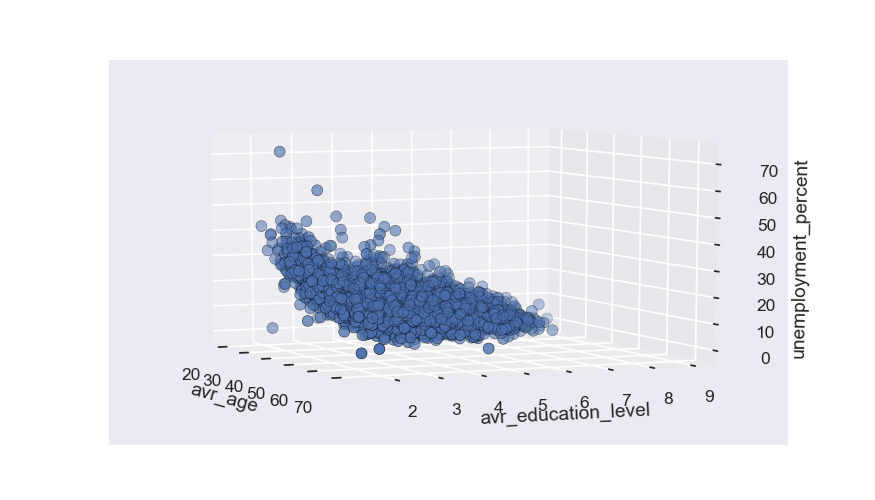

In [9]:
df_plot = data[['avr_age', 'avr_education_level','unemployment_percent']]
scatter3D(df_plot, return_plot = False, figsize=(7,4))


<IPython.core.display.Javascript object>


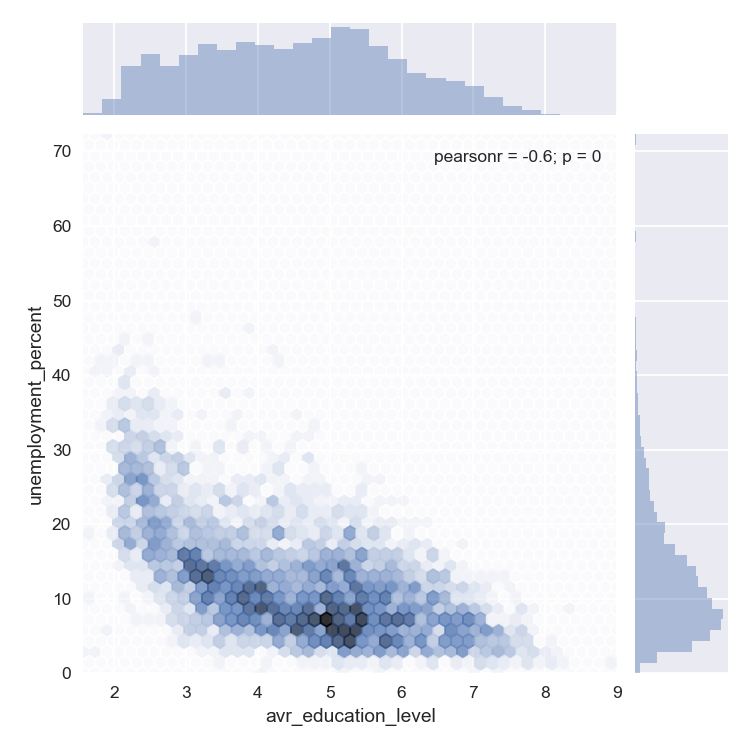

C:\Users\ville_000\Anaconda3\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [10]:
grid2 = sns.jointplot(df_plot.loc[:,'avr_education_level'],df_plot.loc[:,'unemployment_percent'], alpha = 0.8, kind = 'hex')

## Train SOM

In [11]:
# Select data for SOM
df_train = data[['avr_age','avr_education_level','avr_num_cars','unemployment_percent']]

In [12]:
%%R -i df_train

data_train = df_train
# Scale and center all columns
data_train_matrix = as.matrix(scale(data_train))
names(data_train_matrix) = names(data_train)

# larger grid for the small areas example (more samples)
som_grid = somgrid(xdim = 20, ydim=20, topo="hexagonal")  

# Train the SOM model!
som_model = som(data_train_matrix, 
                grid=som_grid, 
                rlen=500, 
                alpha=c(0.1,0.01), 
                keep.data = TRUE )

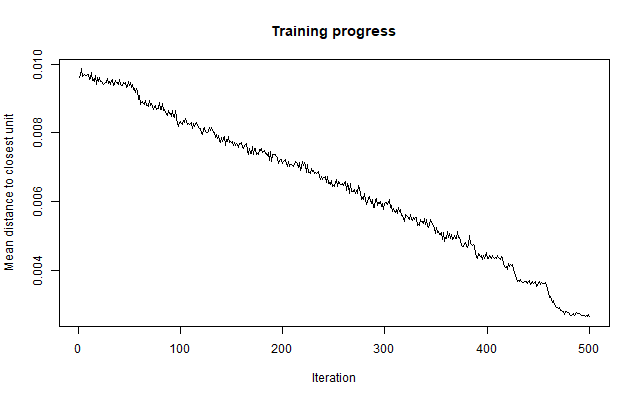

In [31]:
%%R -w 640 -h 400 -u px
plot(som_model, type = "changes")

Node counts: How many samples are mapped to each node on the map

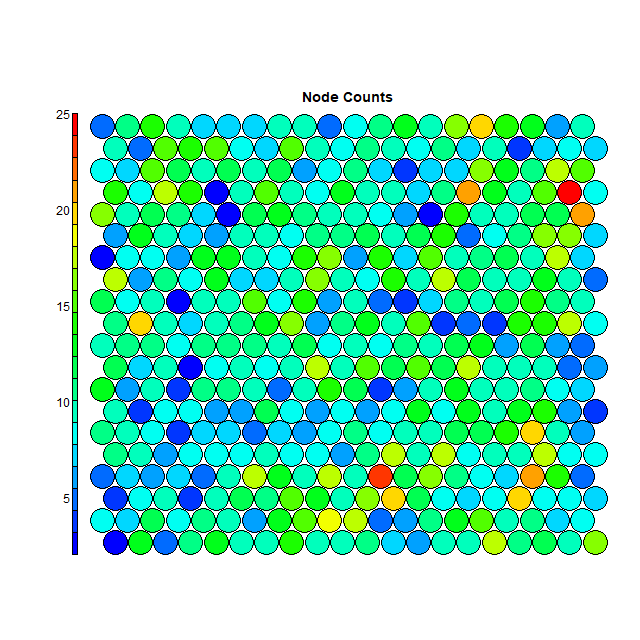

In [29]:
%%R -w 640 -h 640 -u px
source('coolBlueHotRed.R')
plot(som_model, type = "counts", main="Node Counts", palette.name=coolBlueHotRed)

U-matrix: of the distance between each node and its neighbours.

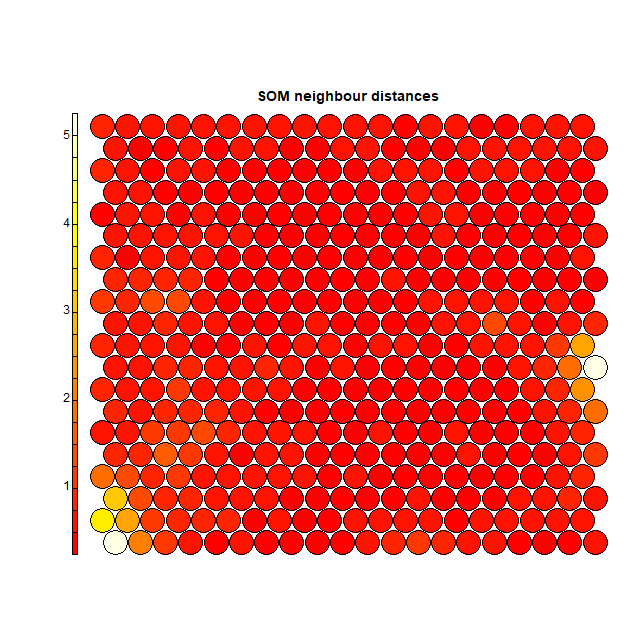

In [27]:
%%R -w 640 -h 640 -u px
plot(som_model, type="dist.neighbours", main = "SOM neighbour distances")

quality: Not sure what this is about yet...

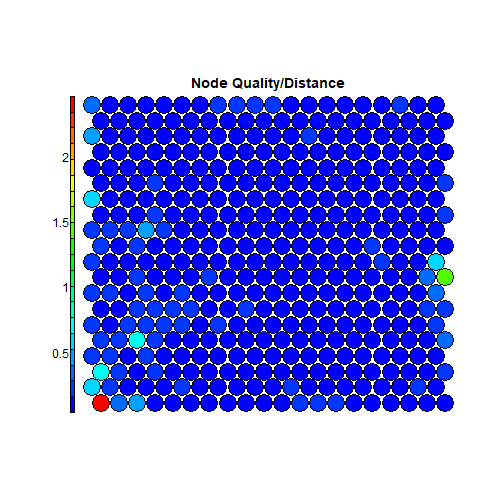

In [124]:
%%R
plot(som_model, type = "quality", main="Node Quality/Distance", palette.name=coolBlueHotRed)

Weight vectors: made up of normalised values of the original variables used to generate the SOM. Each node’s weight vector is representative / similar of the samples mapped to that node.

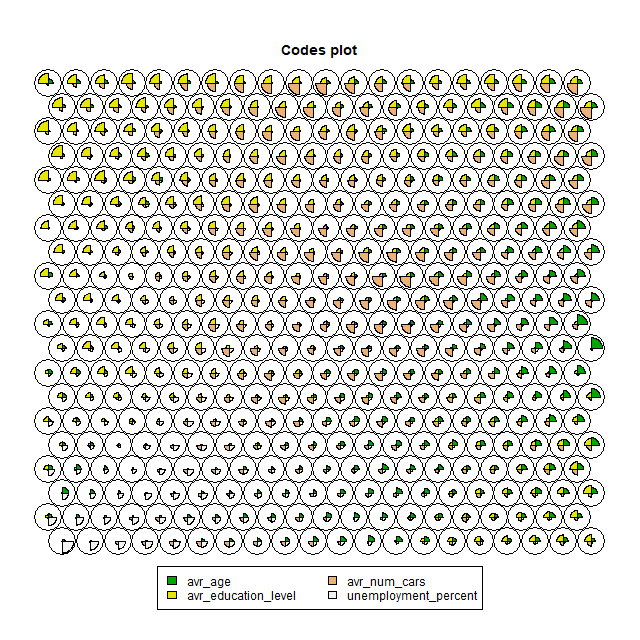

In [35]:
%%R -w 640 -h 640 -u px
plot(som_model, type="codes")

Heatmaps per variable, in normalized units

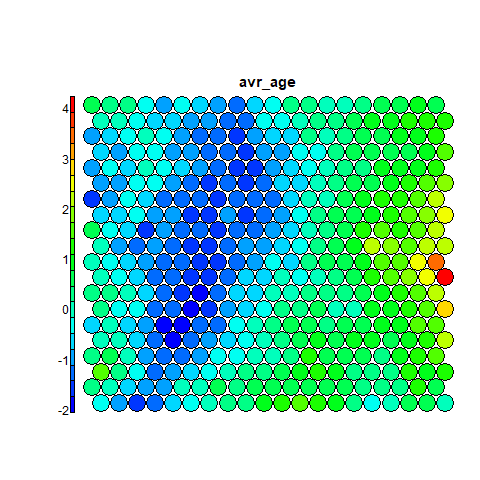

In [18]:
%%R -w 640 -h 640 -u px
# Plot the heatmap for a variable at scaled / normalised values
varno = 1
plot(som_model,
     ,type = "property"
     ,property = getCodes(som_model)[,varno]
     ,main=colnames(getCodes(som_model))[varno]
     ,palette.name=coolBlueHotRed)


Heatmaps per variable, in original units. Won't work if some node is empty! Source provides an attemp to correct this but the code does not work

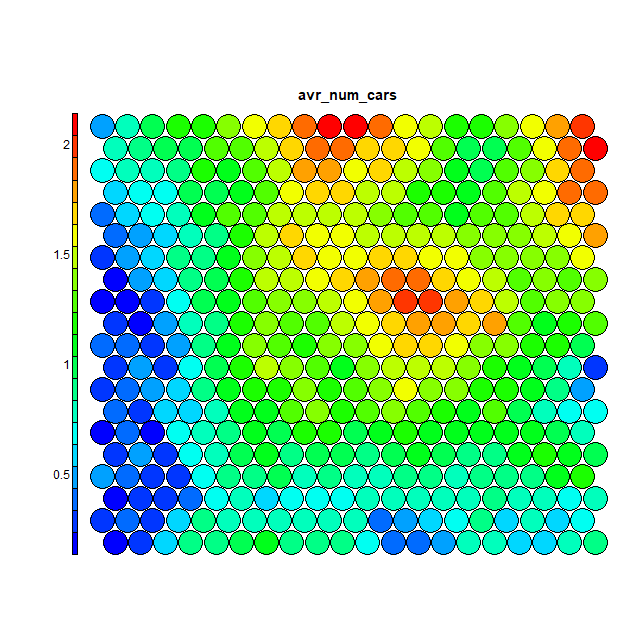

In [125]:
%%R -w 640 -h 640 -u px -o var_unscaled
# Plot the heat map with original data scale. Essentially we take the mean of the 
# variable values of each observations in a given node
var = 3
var_unscaled = aggregate(as.numeric(data_train[,var]), by=list(som_model$unit.classif), FUN=mean, simplify=TRUE)[,2]
plot(som_model, type = "property", property=var_unscaled, main=names(data_train)[var], palette.name=coolBlueHotRed)


Clustering of the SOM map

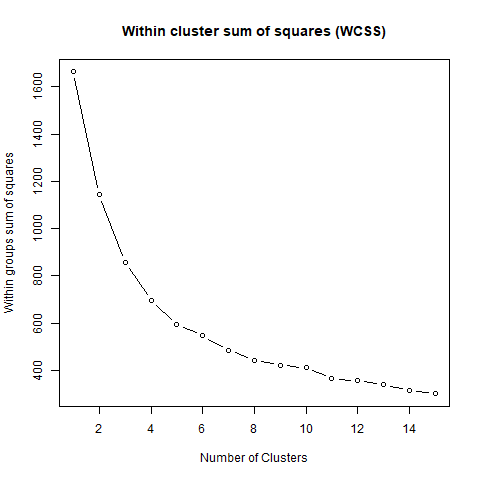

In [52]:
%%R
mydata <- getCodes(som_model)
wss <- (nrow(mydata)-1)*sum(apply(mydata,2,var))
for (i in 2:15) wss[i] <- sum(kmeans(mydata,
                                     centers=i)$withinss)
par(mar=c(5.1,4.1,4.1,2.1))
plot(1:15, wss, type="b", xlab="Number of Clusters",
     ylab="Within groups sum of squares", main="Within cluster sum of squares (WCSS)")

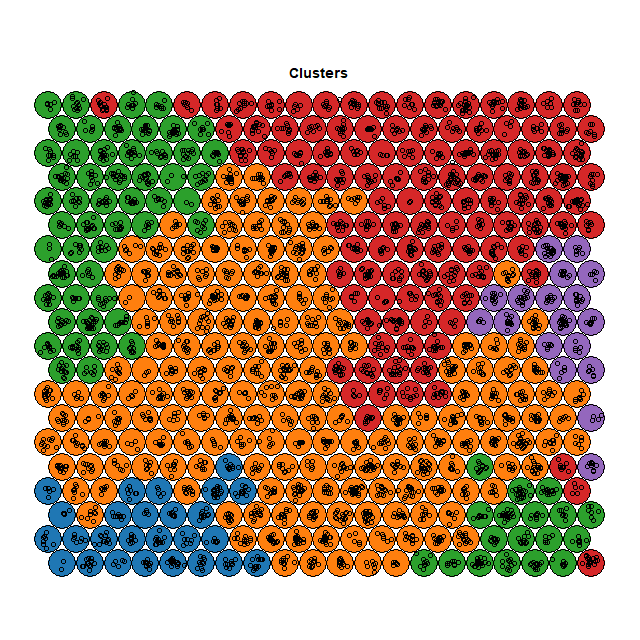

In [103]:
%%R -w 640 -h 640 -u px
pretty_palette <- c("#1f77b4", '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2')
noofclusters = 5
# Form clusters on grid
## use hierarchical clustering to cluster the codebook vectors
som_cluster = cutree(hclust(dist(getCodes(som_model))), noofclusters)

# Show the map with different colours for every cluster
plot(som_model, type="mapping", bgcol = pretty_palette[som_cluster], main = "Clusters")
#add.cluster.boundaries(som_model, som_cluster)

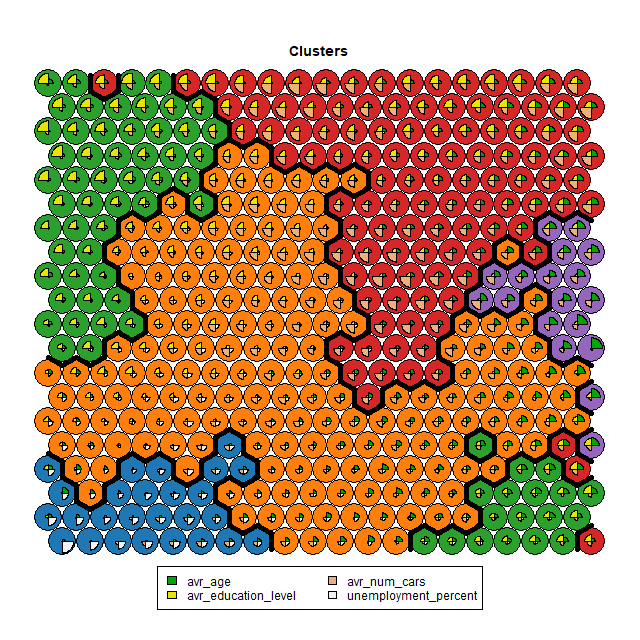

In [104]:
%%R -w 640 -h 640 -u px
plot(som_model, type="codes", bgcol = pretty_palette[som_cluster], main = "Clusters")
add.cluster.boundaries(som_model, som_cluster)

Mapping clusters back to original samples

In [105]:
%%R -o cluster_assignment
# get vector with cluster value for each original data sample
cluster_assignment = som_cluster[som_model$unit.classif]


In [106]:
# for each of analysis, add the assignment as a column in the original data:
data['cluster'] = cluster_assignment

<IPython.core.display.Javascript object>


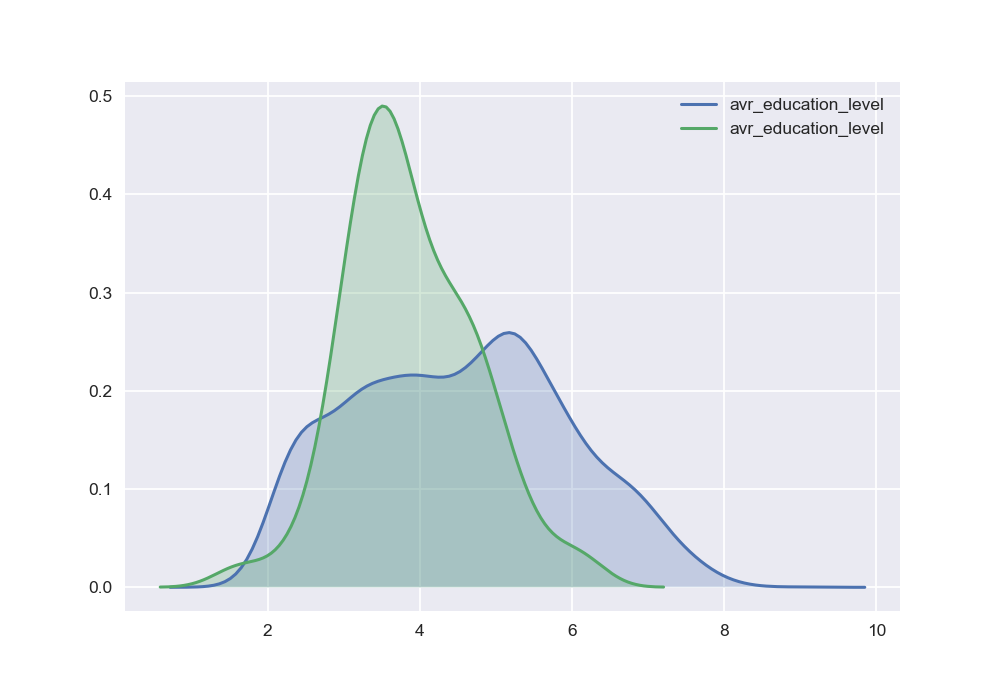

C:\Users\ville_000\Anaconda3\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [122]:
cluster = 5
variable = 'avr_education_level'
fig = plt.figure()
ax = fig.add_subplot(111)
sns.kdeplot(data[variable], ax = ax, shade = True)
sns.kdeplot(data.loc[data['cluster']==cluster,variable], ax = ax, shade = True)